In [ ]:
import torch
# ensuring that the model runs on GPU, not on CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 13.7 MB/s 
     |████████████████████████████████| 132 kB 44.4 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 9.3 MB 50.0 MB/s 
     |████████████████████████████████| 140 kB 54.1 MB/s 
     |████████████████████████████████| 127 kB 72.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import sys
import numpy as np
import random as rn
import pandas as pd
import torch
from pytorch_pretrained_bert import BertModel, BertTokenizer
from torch import nn
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Loading the DataSet
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
#drop duplicates
df.drop_duplicates(inplace=True)
df.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [ ]:
print(df["sentiment"].value_counts())

positive    24884
negative    24698
Name: sentiment, dtype: int64


In [ ]:

df_raw_pos = df[df["sentiment"]== "positive"]
df_raw_neg = df[df["sentiment"]== "negative"]

#drop the difference between the positive and negative set.
df_raw_pos = df_raw_pos.iloc[186: , : ]
df = pd.concat([df_raw_pos,df_raw_neg], ignore_index=True)
#Check for balance now
print(df["sentiment"].value_counts())

positive    24698
negative    24698
Name: sentiment, dtype: int64


#### Sample the data to ovid memory overflow

In [ ]:
df_sampled = df.sample(20000)
print(df_sampled["sentiment"].value_counts())
print(df["sentiment"].value_counts())

negative    10018
positive     9982
Name: sentiment, dtype: int64
positive    24698
negative    24698
Name: sentiment, dtype: int64


#### clean the data as it was scraped.

In [ ]:
import re
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data


df_sampled['review']=df_sampled['review'].apply(lambda z: remove_punctuations(z)).apply(lambda z: remove_html(z))
df_sampled['review']=df_sampled['review'].apply(lambda z: remove_url(z)).apply(lambda z: remove_emoji(z))
# Remove all the special characters
df_sampled['review']=df_sampled['review'].apply(lambda z: re.sub(r'\W', ' ', z))
# remove all single characters
df_sampled['review']=df_sampled['review'].apply(lambda z: re.sub(r'\s+[a-zA-Z]\s+', ' ', z))
# Remove single characters from the start
df_sampled['review']=df_sampled['review'].apply(lambda z: re.sub(r'\^[a-zA-Z]\s+', ' ', z)) 
# Substituting multiple spaces with single space
df_sampled['review']=df_sampled['review'].apply(lambda z: re.sub(r'\s+', ' ', z, flags=re.I))
# Removing prefixed 'br'
df_sampled['review']=df_sampled['review'].apply(lambda z: re.sub(r'^br\s+', '', z))
# if you want to turn reviews into lists. use this. (algorithm dependent)
#df_sampled['review']=df_sampled['review'].apply(lambda z: z.split())
#encode target to numeric
df_sampled['sentiment'] = df_sampled['sentiment'].apply(lambda x: 1 if x == "positive" else 0)

In [ ]:
# Stemming and removing stop words
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

token_pattern = re.compile(r"(?u)\b\w\w+\b")

ps = PorterStemmer()

nltk.download('punkt')
nltk.download('stopwords')

my_stopwords = set(stopwords.words('english'))

df_sampled['review']=df_sampled['review'].apply(lambda x: ' '.join([ps.stem(y) for y in token_pattern.findall(x) if y not in my_stopwords]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_sampled

,review,sentiment
1446,by saying thatI mean that this is not well mad...,1
47226,This is the story of maniac cop who for some r...,0
36521,Cmon people you cant be serious another case o...,0
16668,Ill be quick to address the matters of the fil...,1
12743,Watching The Fox and the Child was an intoxica...,1
...,...,...
37929,I have just wasted my Saturday night watching ...,0
37185,talk about your waste of money im just wonderi...,0
40911,The British claymation series putting witty co...,0
42934,Just when you thought it was safe to go back i...,0


#### split the data 80/20 training/testing

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df_sampled['review'], df_sampled['sentiment'], test_size=0.2, random_state=0)
train_texts, test_labels, test_labels, test_labels = train_texts.tolist(), train_labels.tolist(), test_texts.tolist(), test_labels.tolist()

# Figuring out the length of the sentences after cleaning the texts

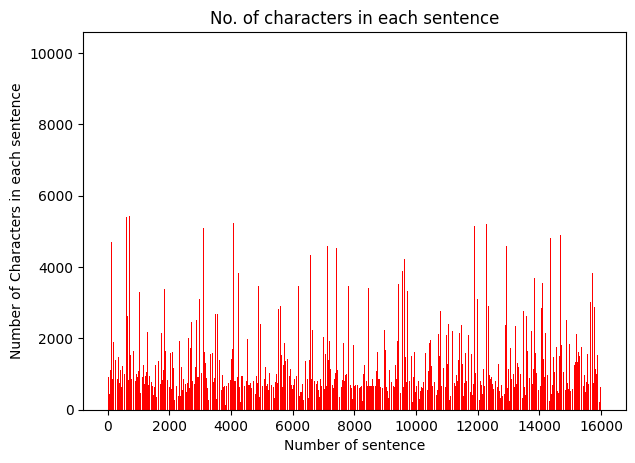

In [ ]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,16001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 249697.57B/s]


In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(16000, 4000)

In [ ]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((16000, 512), (4000, 512))

In [ ]:
train_y = np.array(train_labels) 
test_y = np.array(test_labels) 
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((16000,), (4000,), 0.4988125, 0.50025)

In [ ]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Use logistic regression as a baseline

In [ ]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
baseline_predicted = baseline_model.predict(test_texts)

In [ ]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1999
           1       0.87      0.91      0.89      2001

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



In [ ]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU

100%|██████████| 407873900/407873900 [00:34<00:00, 11897932.35B/s]


In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [ ]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [ ]:
y = bert_clf(x)
y.cpu().detach().numpy()        # Garbage Collector to free up used and cache space

array([[0.5464868 ],
       [0.5581597 ],
       [0.49868414]], dtype=float32)

In [ ]:
# checking GPU Memory to ensure it's not overflowing.
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'5791.379968M'

In [ ]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'5791.379968M'

In [ ]:
# Setting hyper-parameters

BATCH_SIZE = 12
EPOCHS = 5

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [ ]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
print(bert_clf.parameters())

<generator object Module.parameters at 0x7f1d00313ad0>


In [ ]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [ ]:
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

In [ ]:
lr_values = np.arange(1e-3, 1e-2, 0.001)
epsilon_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

values = list(lr_values)

In [ ]:
import numpy as np
import itertools

for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)

        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()


        bert_clf.zero_grad()
        batch_loss.backward()


        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_texts) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  5
1333/1333.3333333333333 loss: 0.12011363023977219 


In [ ]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
np.mean(bert_predicted)

0.52425

In [ ]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1999
           1       0.90      0.95      0.93      2001

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



0.9253294289897511


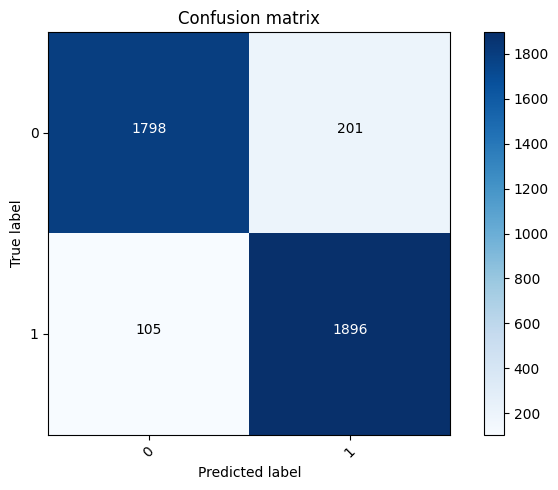

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
cnf_matrix = confusion_matrix(test_y, bert_predicted)
print(f1_score(test_y, bert_predicted))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1911
           1       0.92      0.93      0.93      2089

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000

In [ ]:
!pip install tensorflow_text

### this approach generated horrible results, we used kera layers and we tried optimizing the hyper parameters but it did not bring any improvements. building linear layers proved to be the better approach

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [ ]:
df_sampled

,review,sentiment
1446,by saying thatI mean that this is not well mad...,1
47226,This is the story of maniac cop who for some r...,0
36521,Cmon people you cant be serious another case o...,0
16668,Ill be quick to address the matters of the fil...,1
12743,Watching The Fox and the Child was an intoxica...,1
...,...,...
37929,I have just wasted my Saturday night watching ...,0
37185,talk about your waste of money im just wonderi...,0
40911,The British claymation series putting witty co...,0
42934,Just when you thought it was safe to go back i...,0


In [ ]:
from sklearn.model_selection import train_test_split

# Create train test split for training

X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(df_sampled['review'], df_sampled['sentiment'], test_size=0.2)

In [ ]:
#we used both those layers as a preprocessor and encoder.
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
test_sentence = df_sampled["review"]
print("Test sentence:")
print(test_sentence)
print("Test sentence (word embedding):")
print(get_sentence_embeding([test_sentence]))

In [ ]:
def build_model() -> tf.keras.Model:
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # Neural network layers
    l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) # dropout rate of 0.1 works the best
    l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l) # other activation functions like softmax reduce the accuracy by A LOT

    # Use inputs and outputs to construct a final model
    model = tf.keras.Model(inputs=[text_input], outputs = [l])

    #model.summary()

    return model

In [ ]:
import numpy as np
import itertools
EPOCHS = 2

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

lr_values = np.arange(1e-3, 1e-2, 0.001)
epsilon_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
batch_values = [32]

values = list(itertools.product(lr_values, epsilon_values, batch_values))

print(f"Combinations: {len(values)}")
for lr, ep, batch in values:
  model: tf.keras.Model = build_model()

  print(f"Try adam learning rate of: {lr} and e: {ep} and batch size: {batch}")

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, epsilon=ep),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS)
    
  model.fit(X_train_sampled, y_train_sampled, epochs=EPOCHS, batch_size=batch)
  model.evaluate(X_test_sampled, y_test_sampled)

Combinations: 54
Try adam learning rate of: 0.001 and e: 1e-06 and batch size: 32
Epoch 1/2
500/500 [==============================] - 184s 350ms/step - loss: 0.6833 - accuracy: 0.5748 - precision: 0.5756 - recall: 0.5803
Epoch 2/2
125/125 [==============================] - 45s 353ms/step - loss: 0.6454 - accuracy: 0.6267 - precision: 0.6900 - recall: 0.4284
Try adam learning rate of: 0.001 and e: 1e-05 and batch size: 32
Epoch 1/2
500/500 [==============================] - 177s 349ms/step - loss: 0.6878 - accuracy: 0.5770 - precision: 0.5818 - recall: 0.5420
Epoch 2/2
125/125 [==============================] - 45s 351ms/step - loss: 0.6434 - accuracy: 0.6227 - precision: 0.5896 - recall: 0.7492
Try adam learning rate of: 0.001 and e: 0.0001 and batch size: 32
Epoch 1/2
500/500 [==============================] - 177s 349ms/step - loss: 0.6944 - accuracy: 0.5701 - precision: 0.5656 - recall: 0.5977
Epoch 2/2
125/125 [==============================] - 44s 346ms/step - loss: 0.6590 - accu

In [ ]:
import numpy as np
import itertools
EPOCHS = 5

ADAM_LEARNING_RATE = 0.0007
ADAM_EPSILON = 1e-06


METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

batch_values = [32, 38, 64, 128, 256, 512]

for batch in batch_values:
  model: tf.keras.Model = build_model()

  print(f"Try batch size: {batch}")

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, epsilon=ADAM_EPSILON),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS)
    
  model.fit(X_train_sampled, y_train_sampled, epochs=EPOCHS, batch_size=batch)
  model.evaluate(X_test_sampled, y_test_sampled)

In [ ]:
#best batch value observed was with 32

Try adam learning rate of: 0.002 and e: 1e-05 and batch size: 32
Epoch 1/5
375/375 [==============================] - 128s 335ms/step - loss: 0.6900 - accuracy: 0.5928 - precision: 0.6110 - recall: 0.5039


Epoch 2/5
375/375 [==============================] - 125s 333ms/step - loss: 0.6534 - accuracy: 0.6147 - precision: 0.6167 - recall: 0.6017


Epoch 3/5
375/375 [==============================] - 125s 333ms/step - loss: 0.6552 - accuracy: 0.6198 - precision: 0.6213 - recall: 0.6094

Epoch 4/5
375/375 [==============================] - 126s 336ms/step - loss: 0.6353 - accuracy: 0.6413 - precision: 0.6431 - recall: 0.6314

Epoch 5/5
375/375 [==============================] - 125s 333ms/step - loss: 0.6263 - accuracy: 0.6453 - precision: 0.6467 - recall: 0.6374
250/250 [==============================] - 84s 331ms/step - loss: 0.6130 - accuracy: 0.6631 - precision: 0.6763 - recall: 0.6201